## Overview 🐝
- Population of bees that explore a continuous search space.
- A food source matrix that stores the position and fitness value of each food source
- Selection mechanism that assigns different roles to the bees that determines the probability of the food source.
  - employed, onlooker, or scout
- A perturbation operator that generates a new position for a bee  by using a randomly choosen neighbor
- A set of parameters that control the size of the population, the number of food sources, and the limit of trials for abandoning a food source.

## Uses
- Find the optimal solution to a complex optimization problem, such as clustering data or scheduling tasks
- At each iteration, each employed bee evaluates its assigned food source and generates a new position based on the perturbation operator.
- Scouts share their information with the onlooker bees
- Each onlooker chooses the next food source probabalistically
- After each onlooker completes their search the scouts abandon their food source and randomly generates a new one.
- The algorithm terminates when a predefined criterion is met, such as reaching max iterations or achieving a desired fitness value.


In [ ]:
#@title A simple implementation.

import numpy as np

def fitness(x):
  return -20 * np.exp(-0.2 * np.sqrt(np.mean(x**2))) - np.exp(0.5 * np.sum(np.cos(2 * np.pi * x))) + np.e + 20

# === params ====
num_bees = 100
num_dims = 10
max_iter = 1000
num_food = num_bees // 2 # Max number of food sources
limit = 100 # Limit of trials for abandoning a food source
lower_bound = -5 # Lower bound of the search space.
upper_bound = 5 # Upper bound of the search space.

# === initalize a probability =====
food_matrix = np.random.uniform(lower_bound, upper_bound, (num_food, num_dims + 2))

for i in range(num_food):
  food_matrix[i, -2] = fitness(food_matrix[i, :-2])
  food_matrix[i, -1] = 0

# === Main loop ====
for j in range(max_iter):
  # The employed bee loop should iterate over the food sources
  # Since each employed bee is associated with a food source
  for k in range(num_food):
    neighbor = k
    while neighbor == k:
      neighbor = np.random.randint(0, num_food)
    # choose random dimension index
    dim = np.random.randint(0, num_dims)
    # generate a random value by applying the perturbation operator.
    new_position = food_matrix[k, :-2].copy()
    new_position[dim] = new_position[dim] + np.random.uniform(-1, 1) * (new_position[dim] - food_matrix[neighbor, :-2][dim])

    # apply boundary conditions.
    # The clipping should be applied to the entire new_position array, not just new_position[dim]
    new_position = np.clip(new_position, lower_bound, upper_bound)
    # evaluate the fitness of the new position
    # Pass the entire new_position array to the fitness function
    new_fitness = fitness(new_position)
    # compare the fitness of the new position with the current position
    if new_fitness > food_matrix[k, -2]:
      food_matrix[k, :-2] = new_position.copy()
      food_matrix[k, -2] = new_fitness
      food_matrix[k, -1] = 0
    else:
      food_matrix[k, -1] += 1

  # Calculate the probability of choosing each food source by the onlooker bees based on its fitness value
  # Adjust fitness values to be non-negative for probability calculation
  min_fitness = np.min(food_matrix[:, -2])
  # Add a small epsilon to avoid potential division by zero if all fitness values are the same after shifting
  shifted_fitness = food_matrix[:, -2] - min_fitness + 1e-6

  # Now calculate probabilities based on the shifted fitness
  # Since we want to maximize fitness, higher shifted fitness should mean higher probability
  probabilities = shifted_fitness / np.sum(shifted_fitness)


  # Loop over each onlooker bee
  # There are num_food onlooker bees in this setup
  for l in range(num_food):
    # choose a food source probabalistically
    # Ensure that probabilities are valid (sum to 1 and non-negative) before passing to choice
    if not np.isclose(np.sum(probabilities), 1.0):
        # Re-normalize probabilities if necessary (due to floating point inaccuracies)
        probabilities = probabilities / np.sum(probabilities)

    food = np.random.choice(num_food, p=probabilities)
    # choose a random neighbor index
    neighbor = food
    while neighbor == food:
      neighbor = np.random.randint(0, num_food)
    # Choose a random dimension index
    dim = np.random.randint(0, num_dims)
    new_position =  food_matrix[food, :-2].copy()
    new_position[dim] = new_position[dim] + np.random.uniform(-1, 1) * (new_position[dim] - food_matrix[neighbor, :-2][dim])
    # Apply boundary conditions
    # The clipping should be applied to the entire new_position array
    new_position = np.clip(new_position, lower_bound, upper_bound)
    # Evaluate the fitness of the new position
    # Pass the entire new_position array to the fitness function
    new_fitness = fitness(new_position)
    # Compare the fitness with the old one and update accordingly
    if new_fitness > food_matrix[food, -2]:
      food_matrix[food, :-2] = new_position.copy()
      food_matrix[food, -2] = new_fitness
      food_matrix[food, -1] = 0
    else:
      food_matrix[food, -1] += 1

  # Find the scout bee
  scout = np.argmax(food_matrix[:, -1])
  if food_matrix[scout, -1] >= limit:
    food_matrix[scout, :-2] = np.random.uniform(lower_bound, upper_bound, num_dims)
    # Evaluate fitness of the NEW food source
    food_matrix[scout, -2] = fitness(food_matrix[scout, :-2])
    food_matrix[scout, -1] = 0

  # Find the best food source and its fitness value
  best_food = np.argmax(food_matrix[:, -2])
  # The best fitness is the maximum fitness value
  best_fitness = np.max(food_matrix[:, -2])

print("Best food source: ", food_matrix[best_food, :-2])
print("Best fitness value: ", best_fitness)

















Best food source:  [ 4.62603265 -4.62597736 -4.62600064 -4.62568501  5.          4.62607177
  4.62605686  4.62606336 -4.62605594  4.62597782]
Best fitness value:  14.780637520148707


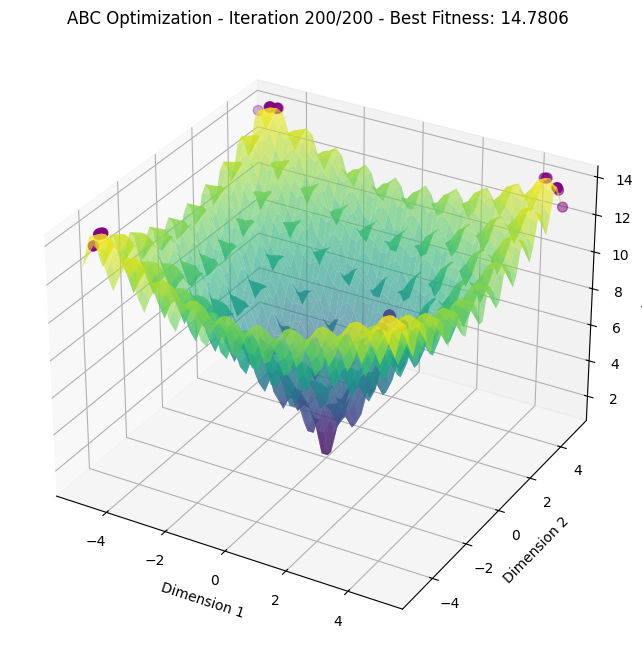

Best food source:  [ 4.61775954 -4.62330523 -4.62852322  4.62666358 -4.6304393   4.62594249
 -4.62312331 -4.62463027  4.62898311  5.        ]
Best fitness value:  14.780577507505344


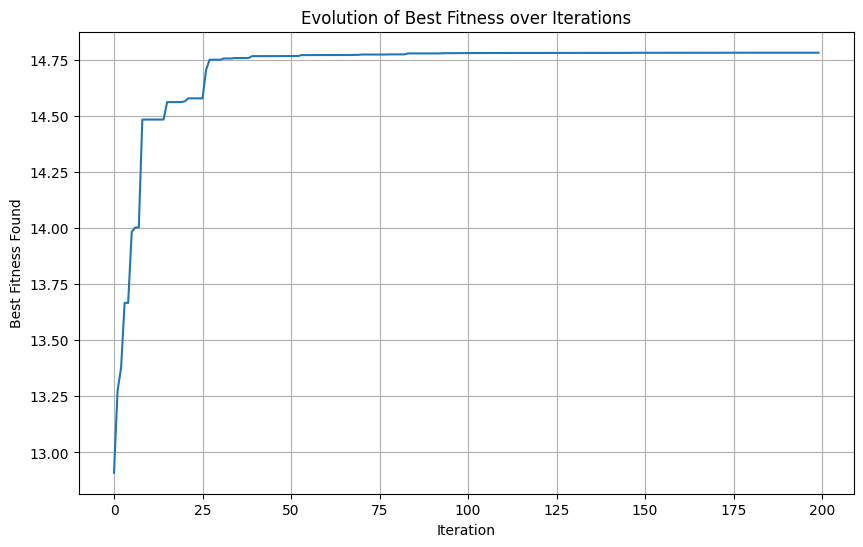

In [ ]:
# prompt: Let's use our artifical bee colony optimizer to visualize an optimization task!
# Run to watch our bees move!
# Pay attention to the scouts searching randomly even after optimization!

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output
import time

# === Visualization Setup ===
# Reduce dimensions for visualization purposes if needed, or plot a 2D slice
# For 3D visualization, we need a 2D function
# Modified fitness_2d to accept and operate on meshgrid arrays
def fitness_2d(x1, x2):
    # Stack x1 and x2 along a new axis to create a 2D array where
    # each column represents a point in the 2D space [x1, x2]
    x = np.stack([x1, x2], axis=-1)
    # Apply the fitness function element-wise across the 2D points
    # Ensure mean and sum operations are done along the last axis (the dimensions of a single point)
    return -20 * np.exp(-0.2 * np.sqrt(np.mean(x**2, axis=-1))) - np.exp(0.5 * np.sum(np.cos(2 * np.pi * x), axis=-1)) + np.e + 20

# === params ====
num_bees = 100
num_dims = 10
max_iter = 200
num_food = num_bees // 2 # Max number of food sources
limit = 100 # Limit of trials for abandoning a food source
lower_bound = -5 # Lower bound of the search space.
upper_bound = 5 # Upper bound of the search space.


# Create a grid for the 2D fitness function landscape
x_surf = np.linspace(lower_bound, upper_bound, 50)
y_surf = np.linspace(lower_bound, upper_bound, 50)
X_surf, Y_surf = np.meshgrid(x_surf, y_surf)
Z_surf = fitness_2d(X_surf, Y_surf)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X_surf, Y_surf, Z_surf, cmap='viridis', alpha=0.6)

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Fitness')
ax.set_title('ABC Optimization on Rastrigin-like function')

# Initialize scatter plot for bee positions (only first two dimensions)
# We will update this scatter plot in each iteration
scatter = ax.scatter([], [], [], color='red', label='Bees', s=50)

# === Main loop with Visualization ===
best_fitness_history = []

# === initalize a probability =====
food_matrix = np.random.uniform(lower_bound, upper_bound, (num_food, num_dims + 2))

for i in range(num_food):
  food_matrix[i, -2] = fitness(food_matrix[i, :-2])
  food_matrix[i, -1] = 0

# === Main loop ====
for j in range(max_iter):
  # The employed bee loop should iterate over the food sources
  # Since each employed bee is associated with a food source
  for k in range(num_food):
    neighbor = k
    while neighbor == k:
      neighbor = np.random.randint(0, num_food)
    # choose random dimension index
    dim = np.random.randint(0, num_dims)
    # generate a random value by applying the perturbation operator.
    new_position = food_matrix[k, :-2].copy()
    new_position[dim] = new_position[dim] + np.random.uniform(-1, 1) * (new_position[dim] - food_matrix[neighbor, :-2][dim])

    # apply boundary conditions.
    # The clipping should be applied to the entire new_position array, not just new_position[dim]
    new_position = np.clip(new_position, lower_bound, upper_bound)
    # evaluate the fitness of the new position
    # Pass the entire new_position array to the fitness function
    new_fitness = fitness(new_position)
    # compare the fitness of the new position with the current position
    if new_fitness > food_matrix[k, -2]:
      food_matrix[k, :-2] = new_position.copy()
      food_matrix[k, -2] = new_fitness
      food_matrix[k, -1] = 0
    else:
      food_matrix[k, -1] += 1

  # Calculate the probability of choosing each food source by the onlooker bees based on its fitness value
  # Adjust fitness values to be non-negative for probability calculation
  min_fitness_val = np.min(food_matrix[:, -2])
  # Add a small epsilon to avoid potential division by zero if all fitness values are the same after shifting
  shifted_fitness = food_matrix[:, -2] - min_fitness_val + 1e-6

  # Now calculate probabilities based on the shifted fitness
  # Since we want to maximize fitness, higher shifted fitness should mean higher probability
  probabilities = shifted_fitness / np.sum(shifted_fitness)


  # Loop over each onlooker bee
  # There are num_food onlooker bees in this setup
  for l in range(num_food):
    # choose a food source probabalistically
    # Ensure that probabilities are valid (sum to 1 and non-negative) before passing to choice
    if not np.isclose(np.sum(probabilities), 1.0):
        # Re-normalize probabilities if necessary (due to floating point inaccuracies)
        probabilities = probabilities / np.sum(probabilities)

    food = np.random.choice(num_food, p=probabilities)
    # choose a random neighbor index
    neighbor = food
    while neighbor == food:
      neighbor = np.random.randint(0, num_food)
    # Choose a random dimension index
    dim = np.random.randint(0, num_dims)
    new_position =  food_matrix[food, :-2].copy()
    new_position[dim] = new_position[dim] + np.random.uniform(-1, 1) * (new_position[dim] - food_matrix[neighbor, :-2][dim])
    # Apply boundary conditions
    # The clipping should be applied to the entire new_position array
    new_position = np.clip(new_position, lower_bound, upper_bound)
    # Evaluate the fitness of the new position
    # Pass the entire new_position array to the fitness function
    new_fitness = fitness(new_position)
    # Compare the fitness with the old one and update accordingly
    if new_fitness > food_matrix[food, -2]:
      food_matrix[food, :-2] = new_position.copy()
      food_matrix[food, -2] = new_fitness
      food_matrix[food, -1] = 0
    else:
      food_matrix[food, -1] += 1

  # Find the scout bee
  scout = np.argmax(food_matrix[:, -1])
  if food_matrix[scout, -1] >= limit:
    food_matrix[scout, :-2] = np.random.uniform(lower_bound, upper_bound, num_dims)
    # Evaluate fitness of the NEW food source
    food_matrix[scout, -2] = fitness(food_matrix[scout, :-2])
    food_matrix[scout, -1] = 0

  # Find the best food source and its fitness value
  best_food_idx = np.argmax(food_matrix[:, -2])
  best_fitness = food_matrix[best_food_idx, -2]
  best_fitness_history.append(best_fitness)


  # === Update Visualization ===
  # Get the current positions (only the first two dimensions for visualization)
  current_positions_2d = food_matrix[:, :2]
  # Calculate the fitness for these 2D points (using the 2D fitness function)
  # This is an approximation for visualization purposes if num_dims > 2
  current_fitness_2d = fitness_2d(current_positions_2d[:, 0], current_positions_2d[:, 1])


  # Update the scatter plot data
  scatter._offsets3d = (current_positions_2d[:, 0], current_positions_2d[:, 1], current_fitness_2d)
  scatter.set_color('purple') # Ensure color is set if needed

  # Update title with current iteration and best fitness
  ax.set_title(f'ABC Optimization - Iteration {j+1}/{max_iter} - Best Fitness: {best_fitness:.4f}')

  # Redraw the plot
  clear_output(wait=True)
  display(fig)
  # time.sleep(0.01) # Add a small delay to see the updates


plt.close(fig) # Close the final plot after the loop

print("Best food source: ", food_matrix[best_food_idx, :-2])
print("Best fitness value: ", best_fitness)

# Plot the fitness history
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history)
plt.xlabel('Iteration')
plt.ylabel('Best Fitness Found')
plt.title('Evolution of Best Fitness over Iterations')
plt.grid(True)
plt.show()